# Tutorial 3 - Construction of 2D free energy surface using WHAM

## Introduction

This notebook illustrates the basic usage of ThermoLIB to construct a 2D free energy profile from umbrella sampling simulations with 2D bias potentials using the WHAM methodology, including error estimation from the theory of the maximum likelihood estimator (MLE). We will also illustrate how we can project the 2D FES onto a 1D FEP. This notebook uses data from simulations for an ethylation reactoin in H-ZSM-5 previously published in XXX.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from thermolib.thermodynamics.fep import FreeEnergySurface2D
from thermolib.thermodynamics.histogram import Histogram2D
from thermolib.tools import read_wham_input, decorrelate
from thermolib.thermodynamics.trajectory import ColVarReader
from thermolib.units import *

import numpy as np

Define some file/path variables

In [3]:
prefix = 'basic_wham2d_' #will be added to all figures made in this notebook
fn_meta = '/home/lvduyfhu/hpc/data_vo/shared/massimo/for_Louis/H-ZSM-5_ethylation/wham_input_2D.txt' #location of the plumed metadata file containing all information of the umbrella sampling

## 2D WHAM without error estimation

First read the input trajectories and define the corresponding bias potentials of each biased simulations included in the metadata file. This is done using the ``read_wham_input`` routine in the code block below. Assuming a metadata file with lines in the form of:

    U14 2.85 -1.4 2000.0 1000.0

we interpret the metadata file using the keywords of the ``read_wham_input`` routine below as follows. A simulation was done with a 2D bias potential of type ``'Parabola2D'`` centered around ``Q01 = 2.85`` and ``Q02 = -1.4`` and with strengths ``kappa1 = 2000.0`` and ``kappa2 = 1000.0``  was given the label ``u14``. In the code block below, we define the unit of ``Q01`` and ``Q02`` both as ``au`` and those of ``kappa1`` and ``kappa2`` both as ``kjmol``. Furthermore, the corresponding trajectory of Q values during this simulation is stored in a file with path ``colvars/COLVAR_U14.dat`` relative to the metadata file directory. This file is then read by ``colvar_reader`` which is an instance of ``ColVarReader`` class and assumes the file to be a colvar file that stores the values of Q1 and in columns ``1`` and ``2`` respectively of a numpy file, both in units ``au``. Finally, the temperature is also read from the metadata file from the line (usually the first line) that starts with ``T``.

In [4]:
colvar_reader = ColVarReader([1,2], units=['au','au'])
temp, biasses, trajectories = read_wham_input(
    fn_meta, colvar_reader, 'colvars/colvar_%s.dat', 
    bias_potential='Parabola2D', q01_unit='au', q02_unit='au', kappa1_unit='kjmol', kappa2_unit='kjmol',
)

The output for the ``read_wham_input`` routine shows (at least if the keyword ``verbose`` is set to ``True``) for each simulation from which file the CV data is read, how many samples are in that simulation as well as which bias potential is used. Next, we construct the 2D probability histogram on the given 2D CV grid (defined by ``bins1`` and ``bins2``) using the WHAM routine.

In [5]:
bins = [np.arange(1,4.025,0.025), np.arange(-2.5,0.025,0.025)]
hist = Histogram2D.from_wham(bins, trajectories, biasses, temp, verbosity='medium')

Initialization ...
Constructing individual histograms for each biased simulation ...
Computing bias on grid ...
Solving WHAM equations (SCF loop) ...
  SCF did not converge!

---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.020s
  bias poten. : 00h 00m 00.825s
  solve scf   : 00h 00m 00.322s
  error est.  : 00h 00m 00.000s
  TOTAL       : 00h 00m 01.168s
---------------------------------------------------------------------


From the histogram, we can construct the corresponding free energy profile. We assume the profile contains a single transition state maximum within the Q-range of ``[-0.2,0.2]``, and a reactant state minimum for lower Q value and product state minimum for higher Q value. This is encoded in the class ``SimpleFreeEnergyProfile``. We then also define the energy reference by setting the reactant state minimum to zero and plot the resulting profile.

<Figure size 640x480 with 0 Axes>

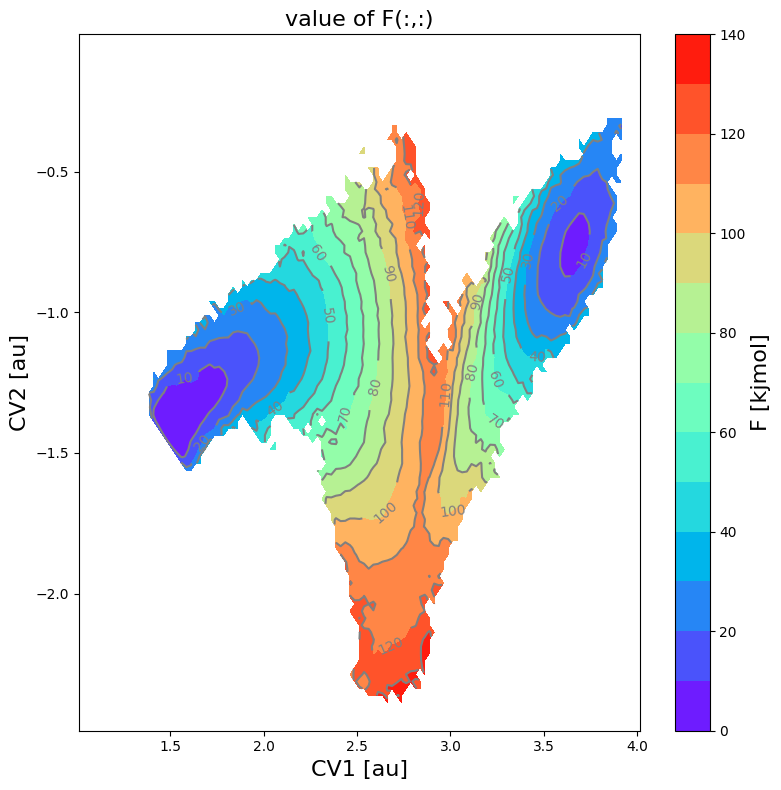

In [6]:
fes = FreeEnergySurface2D.from_histogram(hist, temp)
fes.set_ref(ref='min')
fes.plot(cmap='rainbow', flims=[0,140], ncolors=14)

## 2D WHAM with error estimate

We can now redo the above procedure of construction of the 2D FES including and MLE-F error estimation. However, we therefore, first require the correlation times.

/home/lvduyfhu/miniconda3/envs/test/lib/python3.14/site-packages/thermolib/tools.py:960: OptimizeWarning: Covariance of the parameters could not be estimated
  pars, pcovs = curve_fit(function, upper_envelope_indices, upper_envelope_values, **curve_fit_kwargs)


<Figure size 640x480 with 0 Axes>

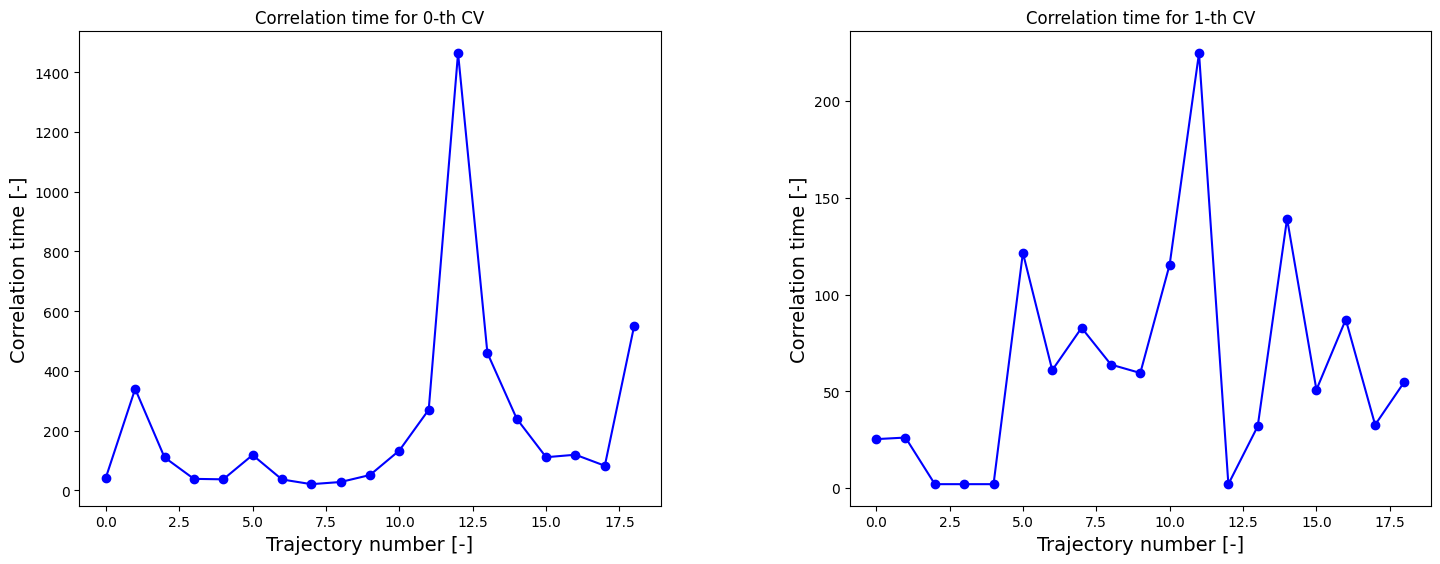

In [7]:
corrtimes = decorrelate(trajectories, plot=True)

We now estimate the 2D FES with error.

In [8]:
bins = [np.arange(1,4.025,0.025), np.arange(-2.5,0.025,0.025)]
hist_err = Histogram2D.from_wham(bins, trajectories, biasses, temp, error_estimate='mle_f_cov', corrtimes=corrtimes, Nscf=10000)

  SCF Converged!

---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.018s
  bias poten. : 00h 00m 00.779s
  solve scf   : 00h 00m 00.477s
  error est.  : 00h 00m 13.697s
  TOTAL       : 00h 00m 14.972s
---------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

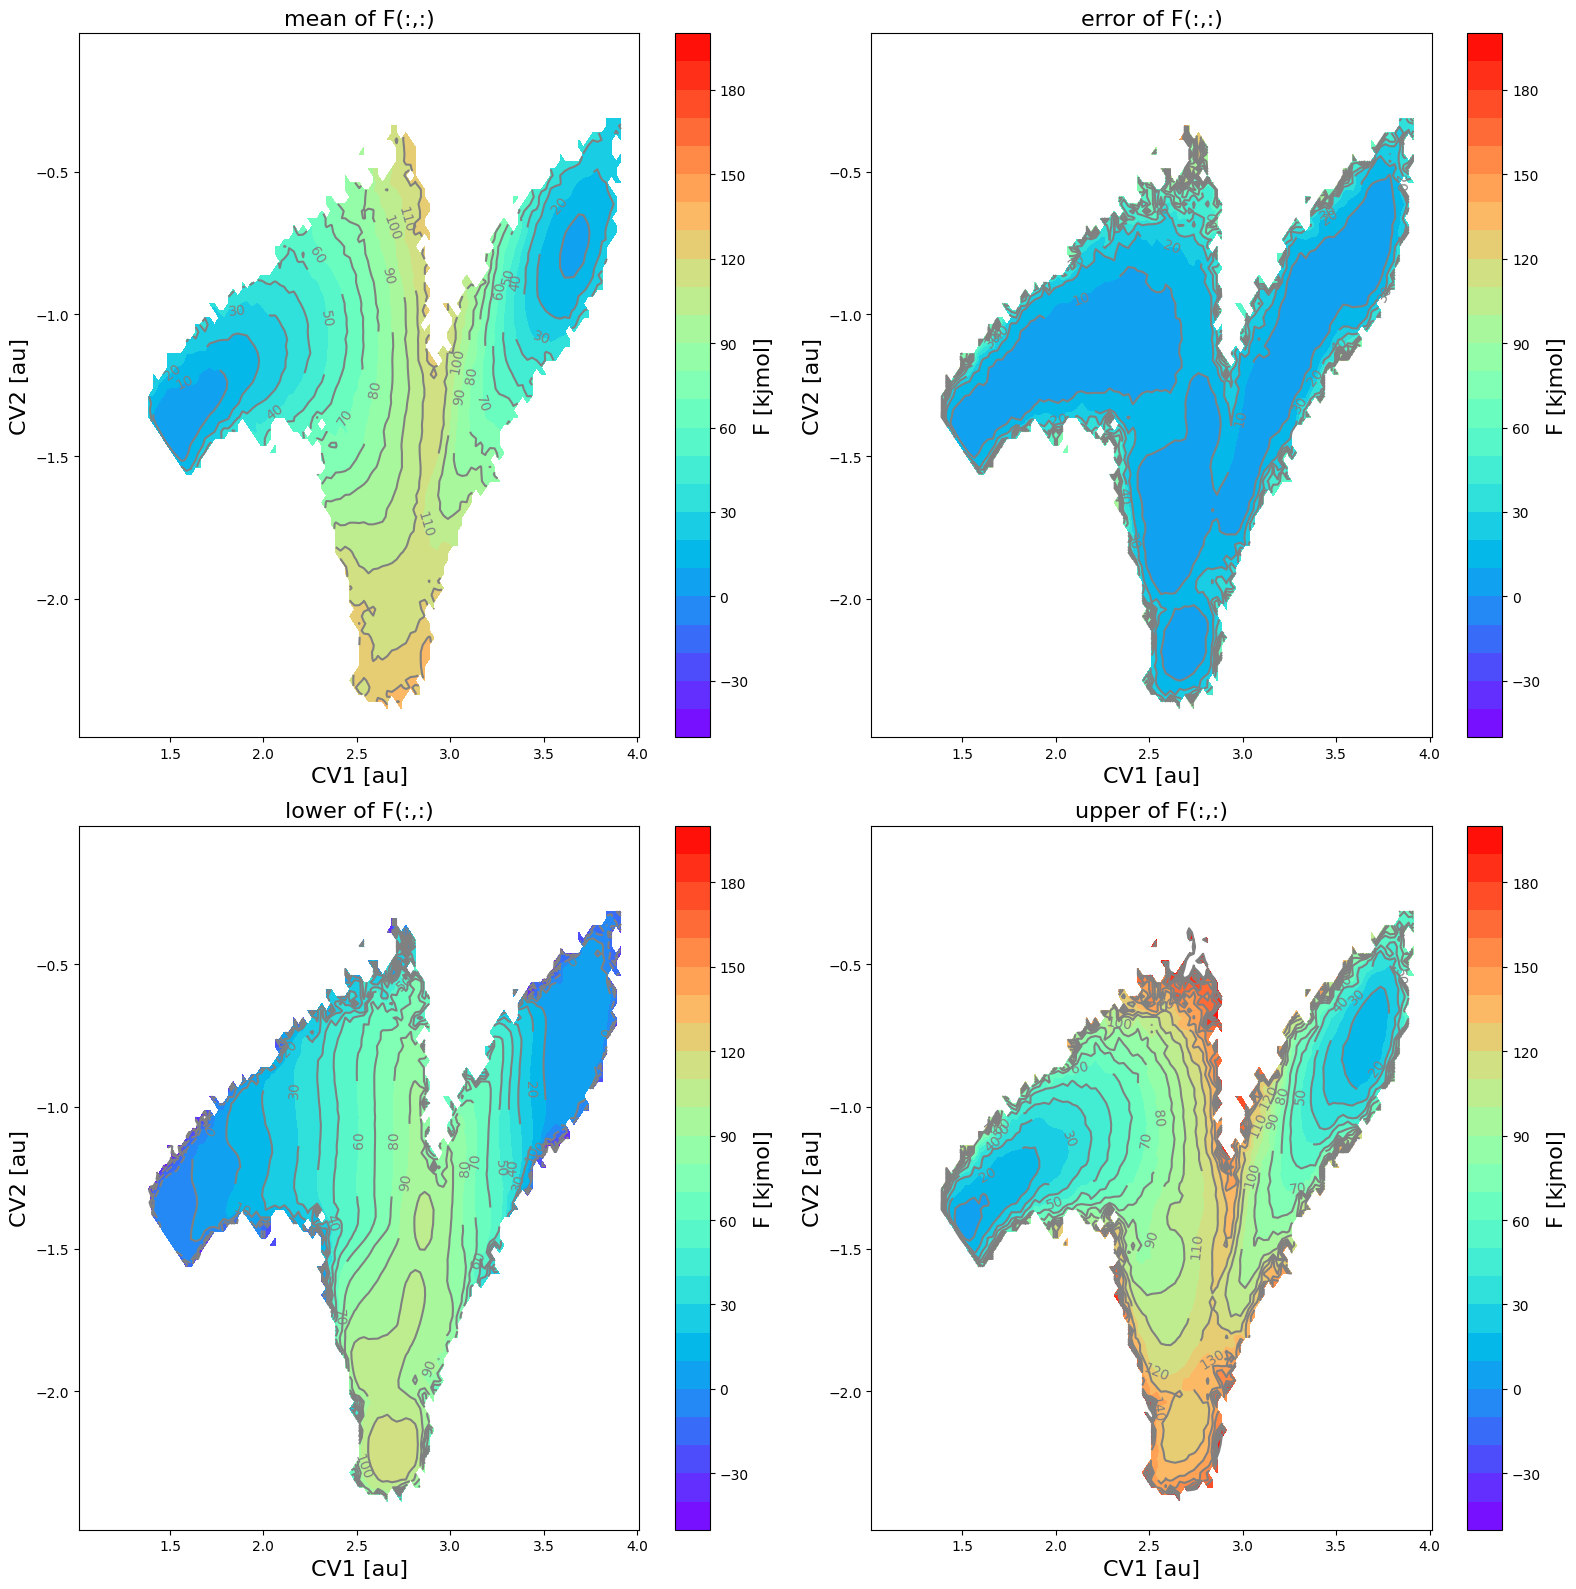

In [13]:
fes_err = FreeEnergySurface2D.from_histogram(hist_err, temp)
fes_err.set_ref(ref='min')
fes_err.plot(obss=['mean', 'error', 'lower', 'upper'], flims=[-50,200], ncolors=25, cmap='rainbow')

In this figure, the various panes represent the following:
- upper left:  mean free energy $\langle F\rangle$
- upper right: two times the standard deviation according the error distribution: $2\sigma$
- lower left:  lower limit of the 2-sigma error interval $\langle F\rangle-2\sigma$
- lower right: upper limit of the 2-sigma error interval $\langle F\rangle+2\sigma$

## Alternative plotting

We can also make a plot of the mean and a sample taken randomly from the error distribution:

<Figure size 640x480 with 0 Axes>

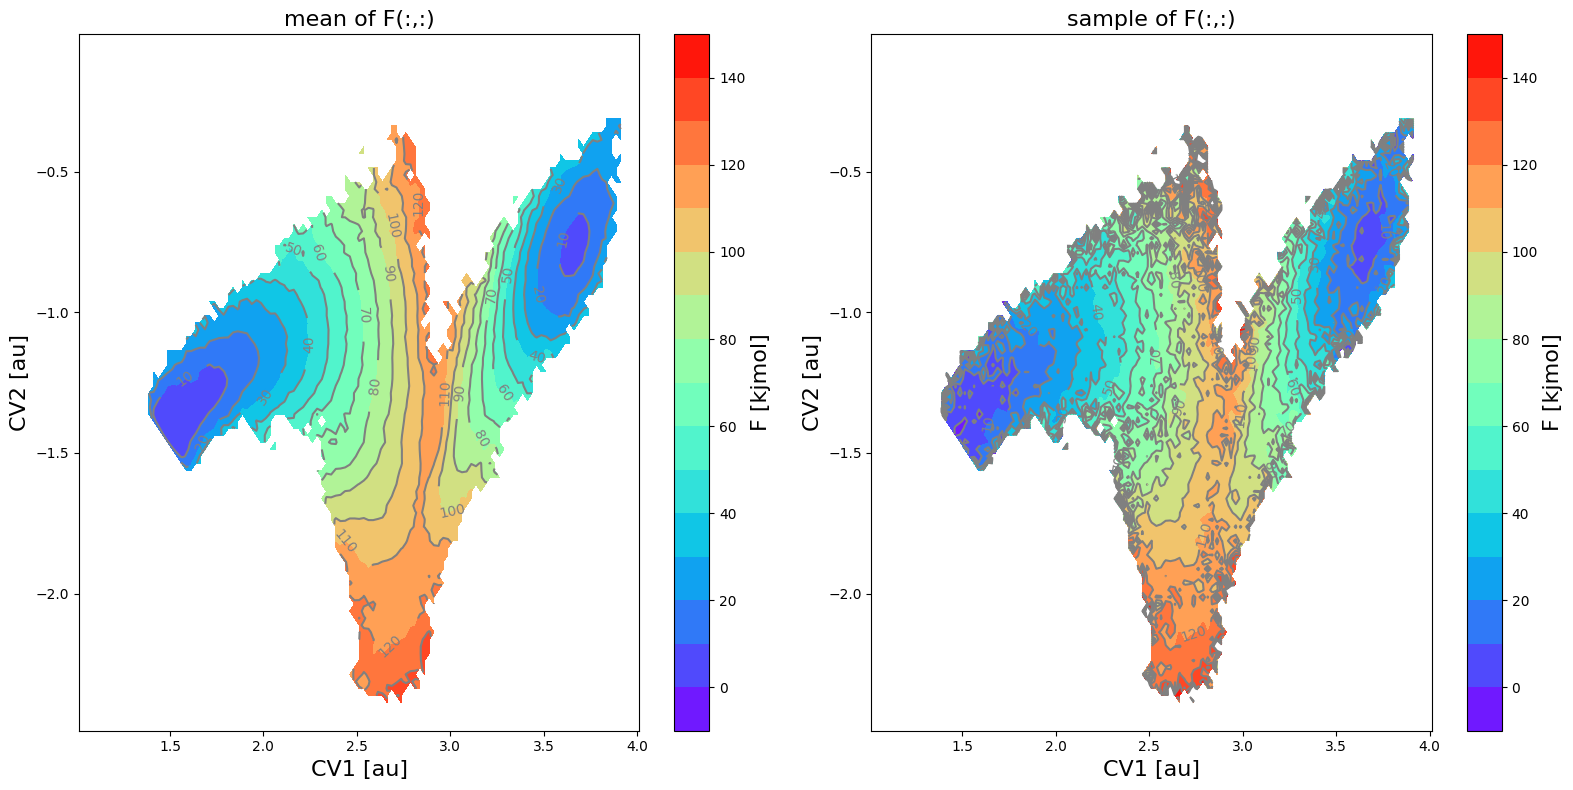

In [10]:
fes_err.plot(obss=['mean', 'sample'], flims=[-10,150], ncolors=16, cmap='rainbow')

We can also make a plot of a slice along 1 of the CVs, in which we take the other fixed to a value at a given index. For example, lets make a 1D plot of the free energy (its mean as well as a random sample) as function of CV1 for a fixed value of CV2 at its 50-th value:

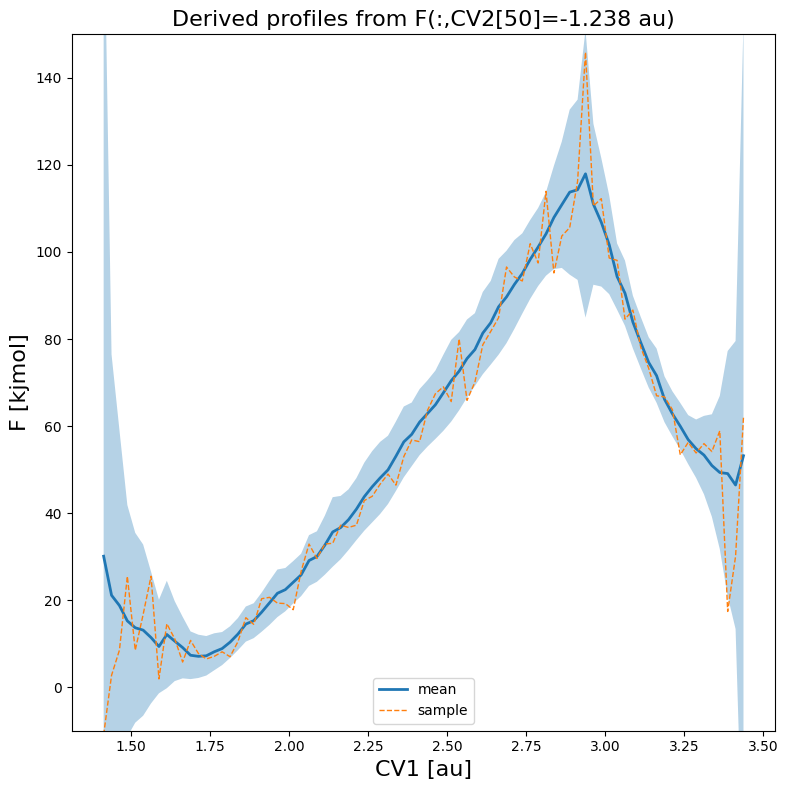

In [11]:
fes_err.plot(slicer=[slice(None), 50], obss=['mean', 'sample'], linewidths=[2,1], linestyles=['-','--'], flims=[-10,150])